# FEUP - AC
## Banking - Predicting a Loan Outcome

### Business understanding

Text

### Exploratory data analysis

Let us start by importing the datasets.

In [55]:
import pandas as pd
import numpy as np

DATA_SOURCE = 'data/'

# Read in the data
accounts = pd.read_csv(DATA_SOURCE + 'account.csv', sep=';')
cards = pd.read_csv(DATA_SOURCE + 'card_dev.csv', sep=';')
clients = pd.read_csv(DATA_SOURCE + 'client.csv', sep=';')
dispositions = pd.read_csv(DATA_SOURCE + 'disp.csv', sep=';')
districts = pd.read_csv(DATA_SOURCE + 'district.csv', sep=';')
loans = pd.read_csv(DATA_SOURCE + 'loan_dev.csv', sep=';')
transactions = pd.read_csv(DATA_SOURCE + 'trans_dev.csv', sep=';')

print(loans)

     loan_id  account_id    date  amount  duration  payments  status
0       5314        1787  930705   96396        12      8033      -1
1       5316        1801  930711  165960        36      4610       1
2       6863        9188  930728  127080        60      2118       1
3       5325        1843  930803  105804        36      2939       1
4       7240       11013  930906  274740        60      4579       1
..       ...         ...     ...     ...       ...       ...     ...
323     6818        9030  961212  155616        48      3242       1
324     5625        3189  961215  222180        60      3703      -1
325     6805        8972  961221   45024        48       938       1
326     7233       10963  961225  115812        36      3217       1
327     7308       11362  961227  129408        24      5392       1

[328 rows x 7 columns]


C:\Users\joaoj\AppData\Local\Temp\ipykernel_29596\2431196884.py:13: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  transactions = pd.read_csv(DATA_SOURCE + 'trans_dev.csv', sep=';')


Plenty of analysis with graphs, distributions, outliers...

### Data preprocessing

Text

#### Processing accounts

The account spreadsheet relates it with the district and date in which it was created, as well with the frequency of issuance of statements with the owner.

The date comes in the from YYMMDD, which is easily extractable to the three different columns that it is aggregating. This will aid the model in detecting important patterns in the year of creation, for example, indicating a global economic crisis or prosperity when the person has created the account.

In [56]:
import src.preprocess as pp

pp.extract_date(accounts, "date")
accounts.rename(columns={"frequency": "account_frequency", "year": "account_year", "month": "account_month", "day": "account_day"}, inplace=True)
accounts.head()

,account_id,district_id,account_frequency,account_year,account_month,account_day
0,576,55,monthly issuance,93,1,1
1,3818,74,monthly issuance,93,1,1
2,704,55,monthly issuance,93,1,1
3,2378,16,monthly issuance,93,1,1
4,2632,24,monthly issuance,93,1,2


#### Processing credit cards

In the credit cards relation, the same concept applies to the date of issuance.

MORE TEXT

In [57]:
cards = pp.extract_date(cards, "issued")
cards.head()

,card_id,disp_id,type,year,month,day
0,1005,9285,classic,93,11,7
1,104,588,classic,94,1,19
2,747,4915,classic,94,2,5
3,70,439,classic,94,2,8
4,577,3687,classic,94,2,15


#### Processing clients

In the clients relation, two foreign references and a date appear once again. However, regarding the latter one, there is an important difference: the day is the actual day plus fifty, if the client is a female, and so we can extract the gender too, here.

In [58]:
client = pp.extract_date(clients, "birth_number", True)
client.head()

,client_id,district_id,year,month,day,gender
0,1,18,70,12,13,female
1,2,1,45,2,4,male
2,3,1,40,10,9,female
3,4,5,56,12,1,male
4,5,5,60,7,3,female


#### Processing dispositions

The disposition describes the rights of clients to operate accounts: only "owners" can ask for loans and issue permanent orders.

There is no clear way to merge this table with loans later on, since the loans table does not refer the disposition used for the loan. Instead, let's focus on the number of dispositions and the ratio of owners of an account, which will give an impression of the nature of the people able to control the account. All humans fight and cheat on each other, or build trust together. Let's discover that pattern in Czech Republic.

In [59]:
no_dispositions = dispositions.groupby("account_id")["type"].count().reset_index(name="number_account_dispositions")
disposition_owner_ratio = dispositions.groupby("account_id")["type"].apply(lambda x: x[x == 'DISPONENT'].count()).reset_index(name="number_account_disponents")
dispositions = dispositions.merge(no_dispositions, on="account_id").merge(disposition_owner_ratio, on="account_id")
dispositions.head()

,disp_id,client_id,account_id,type,number_account_dispositions,number_account_disponents
0,1,1,1,OWNER,1,0
1,2,2,2,OWNER,2,1
2,3,3,2,DISPONENT,2,1
3,4,4,3,OWNER,2,1
4,5,5,3,DISPONENT,2,1


#### Processing districts

The districts relation is quite dense, describing the demographic data of a region. We can extract interesting measures here:

- The commited crimes growth ratio, derived from the evolution of the number of crimes from '95 to '96
- The unemployment rate growth ratio, derived from the evolution of the employment rate from '95 to '96

We also acknowledged that there was one region where the number of crimes and unemployment rate in '95 was not known (`?` was the appearance in the respective column). In order not to discard the entire region data, we'll simply assume that number to be the same as the matching record in '96.

In [60]:
import numpy as np
districts["no. of commited crimes '95"] = np.where(districts["no. of commited crimes '95"].eq("?"), districts["no. of commited crimes '96"], districts["no. of commited crimes '95"])
districts = districts.astype({"no. of commited crimes '95": int, "no. of commited crimes '96": int})
districts["crime_growth"] = districts["no. of commited crimes '96"] / districts["no. of commited crimes '95"]

districts["unemploymant rate '95"] = np.where(districts["unemploymant rate '95"].eq("?"), districts["unemploymant rate '96"], districts["unemploymant rate '95"])
districts = districts.astype({"unemploymant rate '95": float, "unemploymant rate '96": float})
districts["unemploymant_growth"] = districts["unemploymant rate '96"] / districts["unemploymant rate '95"]

districts.drop(axis=1, columns=["no. of commited crimes '95", "unemploymant rate '95", "no. of municipalities with inhabitants < 499","no. of municipalities with inhabitants 500-1999", "no. of municipalities with inhabitants 2000-9999", "no. of municipalities with inhabitants 2000-9999", "no. of municipalities with inhabitants >10000", "name", "region"], inplace=True)
districts["no. of enterpreneurs per 1000 inhabitants"] = districts["no. of enterpreneurs per 1000 inhabitants"] / 1000
districts.rename({"code": "district_id", "no. of inhabitants": "district_no_inhabitants", "no. of cities": "district_no_cities", "ratio of urban inhabitants": "district_urban_inhabitants_ratio", "average salary": "district_average_salary", "unemploymant_growth": "district_unemploymant_growth", "crime_growth": "district_crime_growth", "no. of enterpreneurs per 1000 inhabitants": "districts_entrepreneurs_ratio", "unemploymant rate '96" : "district_unemployment_rate", "no. of commited crimes '96" : "district_crimes_per_year"}, axis=1, inplace=True)
districts['district_crimes_per_year'] = districts['district_crimes_per_year'].astype(int) / districts['district_no_inhabitants']
districts.rename({"district_crimes_per_year": "district_crimes_per_inhabitant"}, axis=1, inplace=True)

districts.head()

,district_id,district_no_inhabitants,district_no_cities,district_urban_inhabitants_ratio,district_average_salary,district_unemployment_rate,districts_entrepreneurs_ratio,district_crimes_per_inhabitant,district_crime_growth,district_unemploymant_growth
0,1,1204953,1,100.0,12541,0.43,0.167,0.082250,1.156752,1.482759
1,2,88884,5,46.7,8507,1.85,0.132,0.030084,1.238536,1.107784
2,3,75232,5,41.7,8980,2.21,0.111,0.037391,0.996105,1.133333
3,4,149893,6,67.4,9753,5.05,0.109,0.039308,1.123570,1.088362
4,5,95616,6,51.4,9307,4.43,0.118,0.031794,1.162080,1.150649


#### Processing loans

The loans relation references an account and the date of loan, which can be extracted. The duration seems to be in months, so let us improve the name of the column. The amounts seems to be in `Czech korunas`, the czech currency, as hinted by the list of regions; we'll convert it to euros for better visualization and understanding of the upcoming results.

In [61]:
loans = pp.extract_date(loans, "date")
loans = pp.korunas_to_euros(loans, "amount")
loans = pp.korunas_to_euros(loans, "payments")
loans.rename(columns = {'payments':'monthly_payment', 'duration': 'duration_months'}, inplace = True)
loans.head()

,loan_id,account_id,amount,duration_months,monthly_payment,status,year,month,day
0,5314,1787,3950.66,12,329.22,-1,93,7,5
1,5316,1801,6801.64,36,188.93,1,93,7,11
2,6863,9188,5208.20,60,86.80,1,93,7,28
3,5325,1843,4336.23,36,120.45,1,93,8,3
4,7240,11013,11259.84,60,187.66,1,93,9,6


#### Processing `trans_dev.csv`

This table contains a lot of information that we cannot directly relate to a loan.

Let us first extract the date and make the withdrawal amounts actually negative, to give the model an impression of the direction of the money flow in and out of the bank.

For now, let us extract some statistical data related to the accounts, which we'll relate to the loans table.

In [62]:
transactions = pp.extract_date(transactions, "date")
transactions = pp.korunas_to_euros(transactions, "amount")
transactions = pp.korunas_to_euros(transactions, "balance")
transactions["amount"] = np.where(transactions["type"].eq("credit"), transactions["amount"], transactions["amount"] * -1)
transactions.head()

,trans_id,account_id,type,operation,amount,balance,k_symbol,bank,account,year,month,day
0,1548749,5270,credit,credit in cash,32.79,32.79,NaN,NaN,NaN,93,1,13
1,1548750,5270,credit,collection from another bank,1833.98,1866.76,NaN,IJ,80269753.0,93,1,14
2,3393738,11265,credit,credit in cash,40.98,40.98,NaN,NaN,NaN,93,1,14
3,3122924,10364,credit,credit in cash,45.08,45.08,NaN,NaN,NaN,93,1,17
4,1121963,3834,credit,credit in cash,28.69,28.69,NaN,NaN,NaN,93,1,19


#### Merging the data

The model will be working on the `loans` table, since the target variable belongs to it. The one foreign key of that table is `account_id`; so, to feed the model with more information about the context of the loan, we should relate concepts to the account for each table.

##### Relating cards to accounts

In [63]:
def get_card_account_id(disp_id):
    try:
        account_id = dispositions.query(f"disp_id == {disp_id}")['account_id'].values[0]
        return account_id
    except:
        return np.nan

cards['account_id'] = cards['disp_id'].apply(get_card_account_id)
cards.rename(columns = {'type':'card_type', 'year': 'card_year', 'month': 'card_month', 'day': 'card_day'}, inplace = True)
cards.head()

,card_id,disp_id,card_type,card_year,card_month,card_day,account_id
0,1005,9285,classic,93,11,7,7753
1,104,588,classic,94,1,19,489
2,747,4915,classic,94,2,5,4078
3,70,439,classic,94,2,8,361
4,577,3687,classic,94,2,15,3050


##### Relating accounts with district data

Text

In [64]:
accounts = accounts.merge(districts, on="district_id").drop(axis=1, columns=["district_id"])
accounts.head()


,account_id,account_frequency,account_year,account_month,account_day,district_no_inhabitants,district_no_cities,district_urban_inhabitants_ratio,district_average_salary,district_unemployment_rate,districts_entrepreneurs_ratio,district_crimes_per_inhabitant,district_crime_growth,district_unemploymant_growth
0,576,monthly issuance,93,1,1,157042,9,33.9,8743,2.43,0.111,0.024796,1.064225,1.292553
1,704,monthly issuance,93,1,1,157042,9,33.9,8743,2.43,0.111,0.024796,1.064225,1.292553
2,192,monthly issuance,93,1,8,157042,9,33.9,8743,2.43,0.111,0.024796,1.064225,1.292553
3,10364,monthly issuance,93,1,17,157042,9,33.9,8743,2.43,0.111,0.024796,1.064225,1.292553
4,497,monthly issuance,93,4,15,157042,9,33.9,8743,2.43,0.111,0.024796,1.064225,1.292553


##### Loading the loans table with data

In [65]:
accounts.rename(columns = {'year':'account_year', 'month':'account_month', 'day':'account_day', 'frequency': 'account_frequency', 'district_id': 'account_district_id'}, inplace=True)
loans = loans.merge(accounts, on="account_id")
loans.head()

# merge with disp with card
# merge disp with account
# merge stuff

,loan_id,account_id,amount,duration_months,monthly_payment,status,year,month,day,account_frequency,...,account_day,district_no_inhabitants,district_no_cities,district_urban_inhabitants_ratio,district_average_salary,district_unemployment_rate,districts_entrepreneurs_ratio,district_crimes_per_inhabitant,district_crime_growth,district_unemploymant_growth
0,5314,1787,3950.66,12,329.22,-1,93,7,5,weekly issuance,...,22,94812,10,81.8,9650,3.67,0.100,0.029574,0.939363,1.085799
1,5316,1801,6801.64,36,188.93,1,93,7,11,monthly issuance,...,13,112709,10,73.5,8369,2.31,0.117,0.023228,0.917309,1.290503
2,6863,9188,5208.20,60,86.80,1,93,7,28,monthly issuance,...,8,77917,5,53.5,8390,2.89,0.132,0.027234,1.020192,1.267544
3,5325,1843,4336.23,36,120.45,1,93,8,3,monthly issuance,...,30,107870,6,58.0,8754,4.31,0.137,0.035858,1.016824,1.125326
4,7240,11013,11259.84,60,187.66,1,93,9,6,weekly issuance,...,14,1204953,1,100.0,12541,0.43,0.167,0.082250,1.156752,1.482759


The disposition and cards relations are merged, and then the resultant relation is merged with the loans table

AxesSubplot(0.125,0.11;0.775x0.77)
iguais
All accounts have only a card! (And is of the acc OWNER)


True

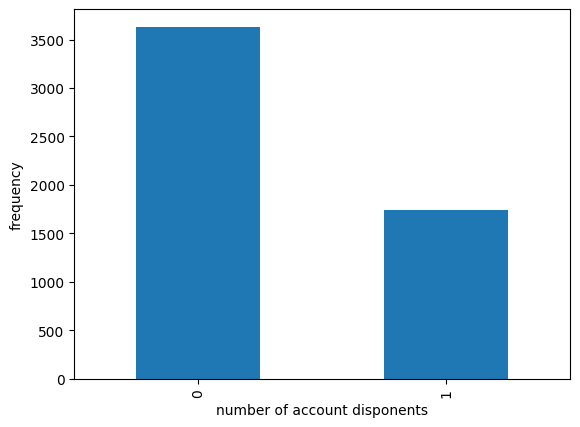

In [66]:
## TODO -> conclusion: only account owners have credit cards

# print("Disps columns: ", dispositions.columns)
# print("Cards columns: ", cards.columns)

# prints number_account_disponents frequency in dispositions
print(dispositions["number_account_disponents"].value_counts().plot(kind='bar', xlabel='number of account disponents', ylabel='frequency'))
teste = dispositions[(dispositions.number_account_disponents > 0)]

teste = teste.merge(cards, on=["disp_id"])

count_acc = len(teste.index)
count_teste = len(teste[teste.account_id_x == teste.account_id_y].index)
if count_acc==count_teste:
    print("iguais")
    teste.drop('account_id_y', inplace=True, axis=1)
    teste.rename(columns = {'account_id_x':'account_id'}, inplace=True)

if (teste.account_id.is_unique == True):
    print("All accounts have only a card! (And is of the acc OWNER)")
teste
teste.card_id.is_unique # True -> significa que só há um disponent/OWNER por card


In [67]:
# DONE: correct -> tests if there is more than one card per account (test follows)
cards_per_account = cards.groupby(['account_id']).size()
cards_per_account[cards_per_account > 1]
if cards_per_account[cards_per_account > 1].empty:
    print("There is just one card per account!")
else:
    # process data? extract feature?
    print("nothing here yet")

cards.account_id.is_unique # True -> se account_id tem valores únicos, significa que só há um cartão por conta 


There is just one card per account!


True

In [68]:
# tests if there is more than one card per account (proof)
# df = pd.DataFrame({
#    'card_id': [1,2,3,4],
#    'account_id': [1,1,1,2]
# })
# cards_per_account = df.groupby(['account_id']).size()
# cards_per_account[cards_per_account > 1]

Checking if there are credit cards more recent than the loans they are associated with 

In [69]:
for idx in loanCards.index:
    if (loanCards.iloc[idx]['year'] < loanCards.iloc[idx]['card_year']):
        print("Found!")
        print("loan yy/mm/dd: ", loanCards.iloc[idx]['year'], "/ " , loanCards.iloc[idx]['month'],"/ ", loanCards.iloc[idx]['day'], "vs acc yy/mm/dd: ", loanCards.iloc[idx]['card_year'], "/ ", loanCards.iloc[idx]['card_month'], "/ ",loanCards.iloc[idx]['card_day'])
    else:
        if (loanCards.iloc[idx]['year'] == loanCards.iloc[idx]['card_year']):
            if (loanCards.iloc[idx]['month'] < loanCards.iloc[idx]['card_month']):
                print("Found!")
                print("loan yy/mm/dd: ", loanCards.iloc[idx]['year'], "/ " , loanCards.iloc[idx]['month'],"/ ", loanCards.iloc[idx]['day'], "vs acc yy/mm/dd: ", loanCards.iloc[idx]['card_year'], "/ ", loanCards.iloc[idx]['card_month'], "/ ",loanCards.iloc[idx]['card_day'])
            else:
                if (loanCards.iloc[idx]['month'] == loanCards.iloc[idx]['card_month']):
                    if (loanCards.iloc[idx]['day'] < loanCards.iloc[idx]['card_day']):
                        print("Found!")
                        print("loan yy/mm/dd: ", loanCards.iloc[idx]['year'], "/ " , loanCards.iloc[idx]['month'],"/ ", loanCards.iloc[idx]['day'], "vs acc yy/mm/dd: ", loanCards.iloc[idx]['card_year'], "/ ", loanCards.iloc[idx]['card_month'], "/ ",loanCards.iloc[idx]['card_day'])

###### It can be concluded that there isn't any credit card more recent than the loan it is associated with

In [70]:
# tests

loanCards = loans.merge(cards, on="account_id")
# loanCards.columns

# res = loanCards[loanCards.card_type == 'junior']

In [71]:
loanCards.index

Int64Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], dtype='int64')

#### Feature engineering

Text

##### Getting the average account balance based on the transactions

In [72]:
average_account_balances = transactions.groupby(["account_id"])["balance"].mean().to_frame()
average_account_balances.rename(columns = {'balance':'account_average_balance'}, inplace = True)
accounts = accounts.merge(average_account_balances, on="account_id")
accounts.head()

,account_id,account_frequency,account_year,account_month,account_day,district_no_inhabitants,district_no_cities,district_urban_inhabitants_ratio,district_average_salary,district_unemployment_rate,districts_entrepreneurs_ratio,district_crimes_per_inhabitant,district_crime_growth,district_unemploymant_growth,account_average_balance
0,576,monthly issuance,93,1,1,157042,9,33.9,8743,2.43,0.111,0.024796,1.064225,1.292553,995.213406
1,704,monthly issuance,93,1,1,157042,9,33.9,8743,2.43,0.111,0.024796,1.064225,1.292553,1424.108906
2,192,monthly issuance,93,1,8,157042,9,33.9,8743,2.43,0.111,0.024796,1.064225,1.292553,1019.869554
3,10364,monthly issuance,93,1,17,157042,9,33.9,8743,2.43,0.111,0.024796,1.064225,1.292553,1404.598889
4,497,monthly issuance,93,4,15,157042,9,33.9,8743,2.43,0.111,0.024796,1.064225,1.292553,2244.168398


In [73]:
# extract more columns

### Training the model

Text

In [74]:
# extract categorical values here later...
# loans_tmp = loans.drop(axis=1, columns=["account_frequency", "card_type"])
loans_tmp = loans.drop(axis=1, columns=["account_frequency"])

for col in loans_tmp.columns:
    print(col)


#### Splitting the data for training

Text

In [75]:
from sklearn.model_selection import train_test_split

target = loans_tmp.status.values
independent = loans_tmp.drop('status', axis=1).values

# Make sure to split by future date later...
x_train, x_test, y_train, y_test = train_test_split(
        independent, target, test_size=0.2, random_state=0)

#### Feeding the model

Evaluate classification model performance with loans table

code the categorical feature into multiple binary features to allow the model to work!! (TBD)

In [76]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score, accuracy_score

# Create a Random Forest Model
random_classifier = RandomForestClassifier(
    n_estimators=10)

# Train it with data
random_classifier.fit(x_train, y_train)

# Predict the test data
predictions = random_classifier.predict(x_test)

print(predictions)

# Check the accuracy
print(recall_score(y_test, predictions, pos_label=-1))
print(accuracy_score(y_test, predictions))

[ 1  1  1  1  1  1  1  1 -1  1  1  1  1 -1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1  1  1]
0.09090909090909091
0.8181818181818182


### Evaluating the model

Text